In [1]:
import pandas as pd
import os
from skimage.transform import resize
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
%matplotlib notebook
from sklearn import svm, metrics, datasets, linear_model, naive_bayes, neighbors, ensemble, linear_model
from sklearn.utils import Bunch
from skimage.feature import greycomatrix
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.metrics import accuracy_score
import joblib
from skimage.transform import resize
from skimage.filters import gaussian, unsharp_mask, gabor
from sklearn.decomposition import PCA
from skimage import exposure, feature, img_as_ubyte
from nilearn.input_data import NiftiMasker
import pywt

from Models.skelm import ELMClassifier

C:\Users\13862\Anaconda3\lib\site-packages\nilearn\datasets\__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [2]:
pywt.wavelist(kind='discrete') # The list of wavelet transform

['bior1.1',
 'bior1.3',
 'bior1.5',
 'bior2.2',
 'bior2.4',
 'bior2.6',
 'bior2.8',
 'bior3.1',
 'bior3.3',
 'bior3.5',
 'bior3.7',
 'bior3.9',
 'bior4.4',
 'bior5.5',
 'bior6.8',
 'coif1',
 'coif2',
 'coif3',
 'coif4',
 'coif5',
 'coif6',
 'coif7',
 'coif8',
 'coif9',
 'coif10',
 'coif11',
 'coif12',
 'coif13',
 'coif14',
 'coif15',
 'coif16',
 'coif17',
 'db1',
 'db2',
 'db3',
 'db4',
 'db5',
 'db6',
 'db7',
 'db8',
 'db9',
 'db10',
 'db11',
 'db12',
 'db13',
 'db14',
 'db15',
 'db16',
 'db17',
 'db18',
 'db19',
 'db20',
 'db21',
 'db22',
 'db23',
 'db24',
 'db25',
 'db26',
 'db27',
 'db28',
 'db29',
 'db30',
 'db31',
 'db32',
 'db33',
 'db34',
 'db35',
 'db36',
 'db37',
 'db38',
 'dmey',
 'haar',
 'rbio1.1',
 'rbio1.3',
 'rbio1.5',
 'rbio2.2',
 'rbio2.4',
 'rbio2.6',
 'rbio2.8',
 'rbio3.1',
 'rbio3.3',
 'rbio3.5',
 'rbio3.7',
 'rbio3.9',
 'rbio4.4',
 'rbio5.5',
 'rbio6.8',
 'sym2',
 'sym3',
 'sym4',
 'sym5',
 'sym6',
 'sym7',
 'sym8',
 'sym9',
 'sym10',
 'sym11',
 'sym12',
 'sym13',

The image loader and data argumentation are splited since the some of data arguementation should not applied to the testing data such as image rotation and noise added. Therefore, only applied to the training data.The function get index is used to oversampling the data with random number generated.

In [3]:
def image_loader(dimension,categories):
    image_dir = 'dataset/image/' 
    if len(categories)==2:
        class_dic = {'meningioma_tumor':0,'glioma_tumor':0, 'pituitary_tumor':0, 'no_tumor':1}
    else:
        class_dic = {'meningioma_tumor':0,'glioma_tumor':1, 'pituitary_tumor':2, 'no_tumor':3}
        
    pathidentity='dataset/'+'label.csv'
    data = pd.read_csv(pathidentity)
    images = []
    flat_data = []
    target = []  
    for index in range(len(data)):        
        labels = categories[class_dic[str(data.iloc[index, 1])]]  
        target.append(labels) 
        file=image_dir + data.iloc[index,0]
#         img = nifti_masker.fit_transform(file)
        img = imread(file)
    
#         img = unsharp_mask(img, radius=3, amount=1)
        img = exposure.equalize_hist(img)
#         img = exposure.equalize_adapthist(img, clip_limit=0.03)
        img_resized = resize(img, dimension, anti_aliasing=True, mode='reflect')
        img_resized = img_resized[:,:,0]
        img_resized = img_resized.flatten()
#         print(img_resized.shape)
#         img_resize =[]
#         for i in range(len(img_resized)):
#             if i%3==0:
#                 img_resize.append(img_resized[i])           
        flat_data.append(img_resized) 
        images.append(img_resized)       
           
        
    flat_data = np.array(flat_data)
    target = np.array(target)
    images = np.array(images)

    return Bunch(data=flat_data,
                 target=target,
                 target_names=categories)

In [4]:
def get_index(index, labels, Is_test):
    if Is_test:
        return index+1, False
    if labels=='no_tumor':
        if np.random.random() > 0.65:  #0.65
            return index, True
    return index+1, False

def image_agumentation(train_image, train_label,thesize, Is_tumor=True,Dimension_2=2,add_noise=True,Is_test=True, levels = 3):
    image_dir = 'dataset/image/' 
    if Is_tumor:
        class_dic = {'meningioma_tumor':0,'glioma_tumor':0, 'pituitary_tumor':0, 'no_tumor':1}
    else:
        class_dic = {'meningioma_tumor':0,'glioma_tumor':1, 'pituitary_tumor':2, 'no_tumor':3}
        
    pywt_wave = 'db3'
    
    X_train =[]
    y_train =[]
    index=0
    labels = str(train_label[index]) 
    Is_same_image = False
    while(index<len(train_image)):        
        labels = str(train_label[index])
        y_train.append(labels) 
        theimage = train_image[index]
        img_resized = []
        for i in range(thesize):
            img_resized.append(theimage[i*thesize:(i+1)*thesize])
        img_resized = np.array(img_resized)
#____________________________GLCM______________________________________ 
#         img_resized = img_as_ubyte(img_resized)
#         img_resized = greycomatrix(img_resized, [1], [0], levels=256, symmetric=False, normed=True)
#____________________________gabor_filter______________________________________ 
#         img_resized, _  = gabor(img_resized, frequency=0.6)

        if np.random.random() > 0.8 and not Is_test:
            img_resized = img_resized[:, ::-1]
        if Is_same_image and np.random.random() > 0.75 and add_noise:
            img_resized = img_resized[:, ::-1]
            img_resized = gaussian(img_resized, sigma=0.25, multichannel=False)
            
        if Dimension_2==2:
            dwt_output = pywt.wavedec2(img_resized, pywt_wave,level=levels)
            swt_output = pywt.swt2(img_resized, pywt_wave, level=levels)
#             print(len(swt_output))
#             print(len(swt_output[0]))
            dwt_cA = dwt_output[0]
            (dwt_cH, dwt_cV, dwt_cD) = dwt_output[1]
            dwt_cA = list(dwt_cA.flatten())
            dwt_cH = list(dwt_cH.flatten())
            dwt_cV= list(dwt_cV.flatten())
            dwt_cD = list(dwt_cD.flatten())
            
            swt_cA,(swt_cH, swt_cV, swt_cD) = swt_output[0]
            swt_cA = list(swt_cA.flatten())
            swt_cH = list(swt_cH.flatten())
            swt_cV= list(swt_cV.flatten())
            swt_cD = list(swt_cD.flatten())            
#             img_resized = dwt_cA + dwt_cH + dwt_cV + dwt_cD
#             img_resized = swt_cA + swt_cH + swt_cV + swt_cD
#             print(len(img_resized))
            img_resized = dwt_cA + dwt_cH + dwt_cV + dwt_cD + swt_cA + swt_cH + swt_cV + swt_cD
        elif Dimension_2==1:  
            img_resized = img_resized.flatten()
            img_dwtA = img_resized.copy()
            img_swtA = img_resized.copy()        
            for i in range(levels):
                img_dwtA,img_dwtD = pywt.dwt(img_dwtA, pywt_wave)
                img_swt = pywt.swt(img_swtA, pywt_wave) 
                img_swtA,img_swtD=img_swt[0]
            img_dwtA = list(img_dwtA)   
            img_swtA = list(img_swtA)
            img_resized = img_dwtA+ img_swtA
        else:
            img_resized = list(img_resized.flatten())
            
        X_train.append(img_resized) 
        index, Is_same_image=get_index(index, labels, Is_test) 
        
    return X_train, y_train

In [5]:
Tumnor_detection=True # Switch Tumnor_detection to True for task A and False for task B
thesize=64 # the image size thesize * thesize
if Tumnor_detection:
    classes = ['tumor', 'no_tumor']
    num_classes=2
else:  
    # 0 for meningioma, 1 for glioma, 2 for pituitary tumor
    classes = ['meningioma_tumor','glioma_tumor', 'pituitary_tumor', 'no_tumor']
    num_classes=4
image_dataset = image_loader((thesize,thesize),categories=classes)

C:\Users\13862\Anaconda3\lib\site-packages\skimage\exposure\exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


In [43]:
k_flod = True # change to flase for single division training, ture for k fold training
add_noise = False # change to add noise to the training image
No_oversampling = False # change to enable the oversampling in training set
n_levels=3 # the levels for wavelet transform
k_counter=1 #  count the fold epoch
k_res=[]
k=5
Dimension_2=0 # 0 for preprocessed image, 1 for 1d wavelet transform, 2 for 2d wavelet transform
# Kernel = ["linear",'poly',"rbf","sigmoid"] # kernel nema for SVM
# param_grid = {} # for other ML classofoers
param_grid = [
  {'C': [1, 10, 100, 1000], 'gamma': [0.001], 'kernel': ['rbf']},
 ] # for SVM
# model=linear_model.LogisticRegressionCV(max_iter=2000) # define the model used for the classifier
# model=linear_model.RidgeClassifierCV()
# model=linear_model.SGDClassifier()
# model=linear_model.Perceptron()
# model = svm.LinearSVC(max_iter=70000)
# model= ensemble.RandomForestClassifier()

# model = naive_bayes.GaussianNB()
# model = naive_bayes.MultinomialNB()#positive x only (minmax scalar)
# model = neighbors.KNeighborsClassifier()
# model = ensemble.GradientBoostingClassifier()
# model = ensemble.AdaBoostClassifier()

model = svm.SVC()

if k_flod:
    kf = KFold(n_splits=k, shuffle=True,random_state=33)
    for train, test in kf.split(image_dataset.data):
#         clf = ELMClassifier()
        clf = GridSearchCV(model, param_grid, return_train_score=True) #initlise the parameter in the classifier
        X_train, X_test, y_train, y_test = image_dataset.data[train], image_dataset.data[test], image_dataset.target[train], image_dataset.target[test]
        X_train, y_train = image_agumentation(X_train, y_train,thesize, Is_tumor=Tumnor_detection,Dimension_2=Dimension_2,add_noise=add_noise ,Is_test=No_oversampling, levels = n_levels)
        X_test, y_test = image_agumentation(X_test, y_test,thesize, Is_tumor=Tumnor_detection,Dimension_2=Dimension_2,add_noise=False ,Is_test=True, levels = n_levels)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(k_counter, "Classification results for - \n{}:\n{}\n".format(
            clf, metrics.classification_report(y_test, y_pred)))
        k_acc=accuracy_score(y_pred,y_test)*100
        k_res.append(k_acc)
        k_counter+=1
    average_acc=sum(k_res)/k 
    print(f"The model is {average_acc}% accurate")
else:
    X_train, X_test, y_train, y_test = train_test_split(
    image_dataset.data, image_dataset.target, test_size=0.2,random_state=33)

    # nifti_masker = NiftiMasker(
    #     standardize=False,
    #     smoothing_fwhm=2,
    #     memory='nilearn_cache')  # cache options
    # print(X_train)
    # X_train = nifti_masker.fit_transform(X_train)
    # X_test = nifti_masker.fit_transform(X_test)
    
    
    clf = GridSearchCV(model, param_grid, return_train_score=True)
#     clf = ELMClassifier()
    X_train, y_train = image_agumentation(X_train, y_train,thesize, Is_tumor=Tumnor_detection,Dimension_2=Dimension_2,add_noise=add_noise ,Is_test=False, levels = n_levels)
    X_test, y_test = image_agumentation(X_test, y_test,thesize, Is_tumor=Tumnor_detection,Dimension_2=Dimension_2,add_noise=False ,Is_test=True, levels = n_levels)
    clf.fit(X_train, y_train)
    joblib.dump(clf, 'SVM_tumordection.pkl') 
    y_pred = clf.predict(X_test)
    print("Classification report for - \n{}:\n{}\n".format(
        clf, metrics.classification_report(y_test, y_pred)))
    print(f"The model is {accuracy_score(y_pred,y_test)*100}% accurate")

1 Classification report for - 
GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001],
                          'kernel': ['rbf']}],
             return_train_score=True):
              precision    recall  f1-score   support

    no_tumor       0.85      0.78      0.81        87
       tumor       0.96      0.98      0.97       513

    accuracy                           0.95       600
   macro avg       0.91      0.88      0.89       600
weighted avg       0.95      0.95      0.95       600


2 Classification report for - 
GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001],
                          'kernel': ['rbf']}],
             return_train_score=True):
              precision    recall  f1-score   support

    no_tumor       0.84      0.77      0.80        91
       tumor       0.96      0.97      0.97       509

    accuracy                           0.94       600
   macro avg       0.9

In [41]:
k_res

[94.0,
 95.66666666666667,
 94.66666666666667,
 95.83333333333334,
 97.16666666666667]

In [15]:
# clf = joblib.load('SVM_tumordectionACC96_rbf_2d_as.pkl')   # load the model parameter

<IPython.core.display.Javascript object>


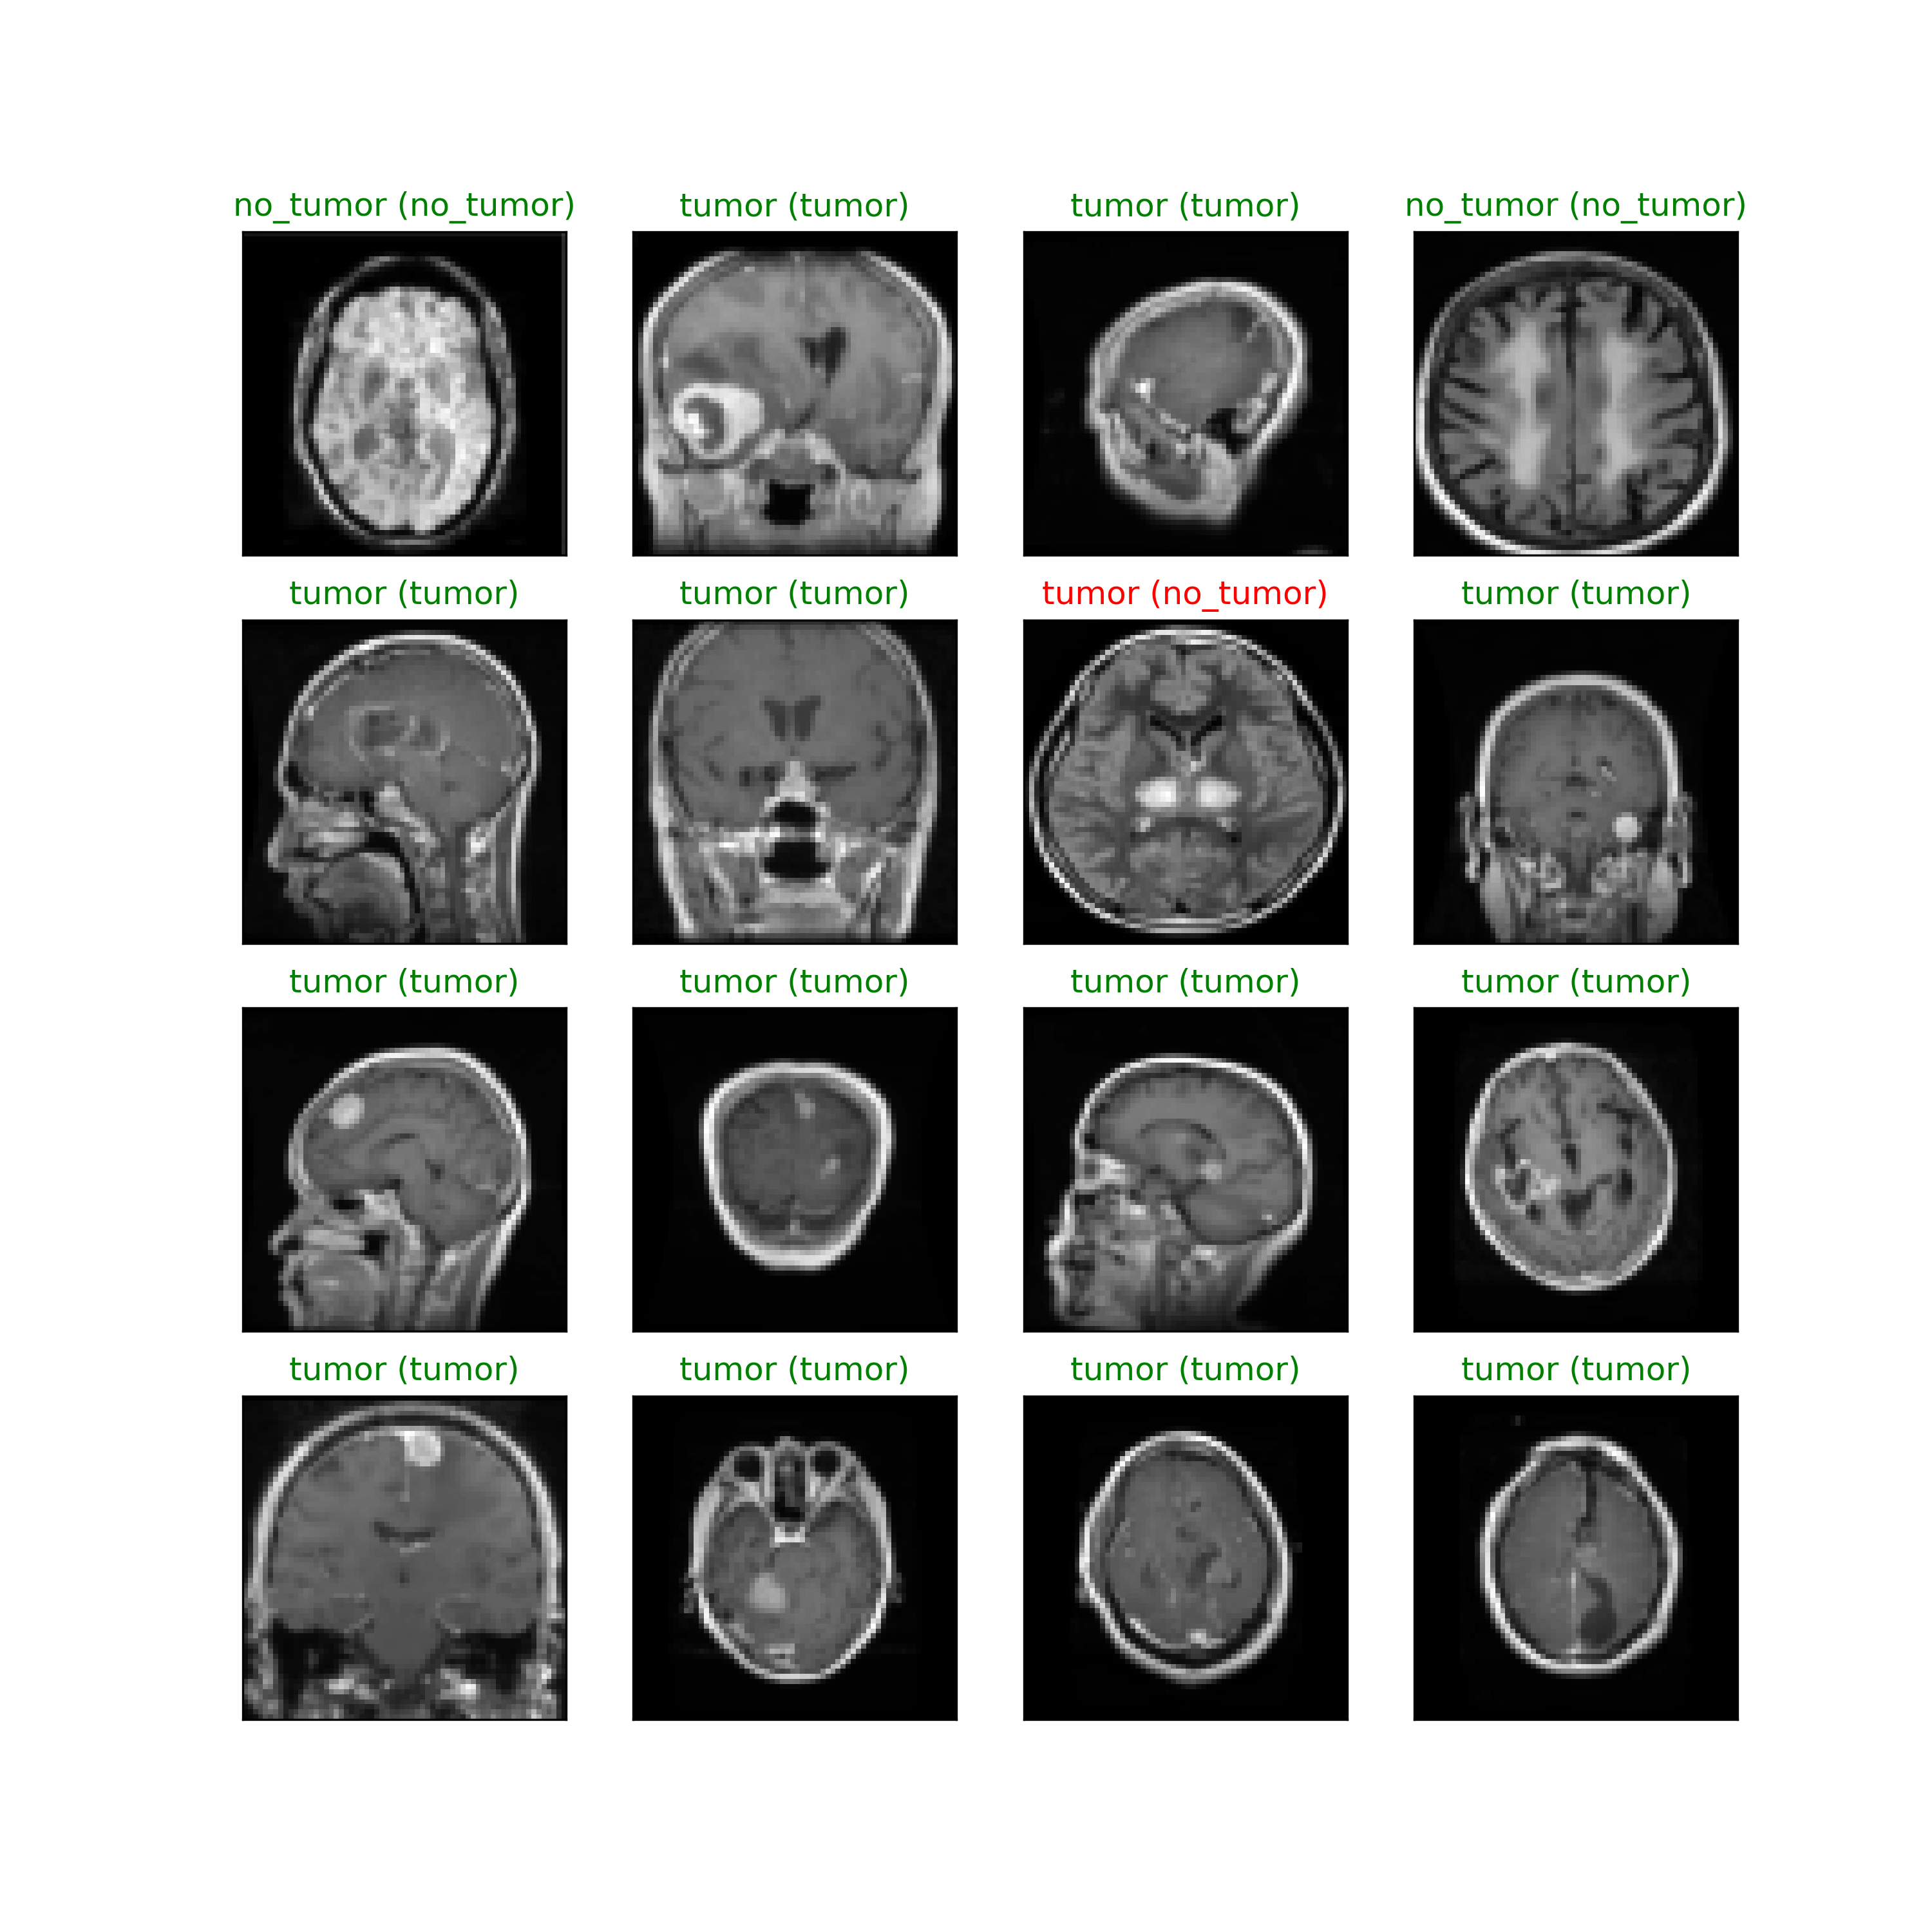

In [35]:
batch_size=16
output = clf.predict(X_test[:batch_size])
labels = y_test[:batch_size]

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(10,10))
# display 20 images
row_size=4
for idx in range(batch_size):
    ax = fig.add_subplot(row_size, batch_size/row_size, idx+1, xticks=[], yticks=[])
    img_resize=[]
    theimg=X_test[idx]
    for i in range(thesize):
        img_resize.append(theimg[i*thesize:(i+1)*thesize])
    img_resize=np.array(img_resize)
    plt.imshow(img_resize, cmap=plt.get_cmap('gray'))
    ax.set_title("{} ({})".format(output[idx], labels[idx]),
                 color=("green" if output[idx]==labels[idx] else "red"))

In [48]:
counter=[0 for i in range(num_classes)] # print the class size
for item in y_test:
    if item=='tumor':
        counter[0]+=1
    else:
        counter[1]+=1
for item in y_train:
    if item=='tumor':
        counter[0]+=1
    else:
        counter[1]+=1    
print(counter)

[2546, 625]


In [50]:
counter=[0 for i in range(4)] # print the class size
        
pathidentity='C:/Users/13862/Desktop/AMLS_assignment/dataset/'+'label.csv'
data = pd.read_csv(pathidentity) 
class_dic = {'meningioma_tumor':0,'glioma_tumor':1, 'pituitary_tumor':2, 'no_tumor':3}
for index in range(len(data)):        
    if str(data.iloc[index, 1])=='meningioma_tumor':
        counter[0]+=1
    elif str(data.iloc[index, 1])=='glioma_tumor':
        counter[1]+=1
    elif str(data.iloc[index, 1])=='pituitary_tumor':
        counter[2]+=1
    elif str(data.iloc[index, 1])=='no_tumor':
        counter[3]+=1
        
print(counter)

[855, 860, 831, 454]


In [ ]:
from sklearn.feature_selection import RFE # testing the performance of SVM-REF
y_train_RFE=[]
class_dic = { 'tumor':0, 'no_tumor':1}
for item in y_train:
    y_train_RFE.append(class_dic[item])
estimator = svm.SVR(kernel="linear", C=1)
selector = RFE(estimator, n_features_to_select=1, step=1)
selector = selector.fit(X_train, y_train_RFE)